In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pyslha
import glob
from pandas import json_normalize 
import pandas as pd
import os

In [2]:
defaultPars = {'figure.figsize': (5, 4),
               'lines.markersize' : 4,
               'axes.titlesize' : 13,
               'font.size' : 13,
               'axes.labelsize' : 16,
               'xtick.labelsize' : 13,
               'ytick.labelsize' : 13,
               'legend.fontsize' : 10,
               "text.usetex": True,
               "font.family": "sans-serif",
               "font.sans-serif": ["Helvetica"],
               'font.family':'Times New Roman', 
               'font.serif':'Times New Roman',
               "savefig.dpi" : 300,
               'contour.linewidth' : 2.0,
               'lines.linewidth' : 2.0,
               'axes.grid' : True,
               'grid.linewidth' : 0.5,
               'grid.color' : 'lightgray',
               'axes.axisbelow' : True
               }
plt.rcParams.update(defaultPars)

In [3]:
# data = np.genfromtxt("pp2Sd_scan/Events/scan_run_[01-19].txt",names=True)
# dataQ = np.genfromtxt("pp2Sd_scan/Events/scan_run_[20-38].txt",names=True)

In [4]:
slhaData = []
for f in glob.glob('./decays_H/Events/run*/run*.txt'):
    with open(f,'r') as ff:
        slha = ff.read().split('<slha>')[1].split('</slha>')[0]
    slha = pyslha.readSLHA(slha)
    massDict = dict([[str(key),abs(val)] for key,val in slha.blocks['MASS'].items() if key >= 52])
    extparDict = dict([[str(key),val] for key,val in slha.blocks['NPINPUTS'].items()])    
    widthDict = dict([[str(key),val.totalwidth] for key,val in slha.decays.items() if key >= 52])
    BRsDict = {}
    for pdg,val in slha.decays.items():
        initialState = str(pdg)
        BRsDict[initialState] = {}
        for dec in val.decays:
            if dec.br < 1e-7: continue            
            finalState = ','.join([str(pid) for pid in sorted(dec.ids)])
            BRsDict[initialState][finalState] = dec.br
    slhaDict = {'filename' : os.path.basename(f), 'mass' : massDict, 'width' : widthDict, 'BRs' : BRsDict, 'extpar' : extparDict}
    slhaData.append(slhaDict)

In [5]:
slhaDF = json_normalize(slhaData)
slhaDF.set_index(['filename'],inplace=True)

In [6]:
ptc_labels = {5000023 : r'\chi_1', 5000022 : r'\chi_0', 55 : 'S', 21 : 'g', 5 : 'b', -5 : r'\bar{b}', 15 : r'\tau^-', -15 : r'\tau^+', 25 : 'h'}

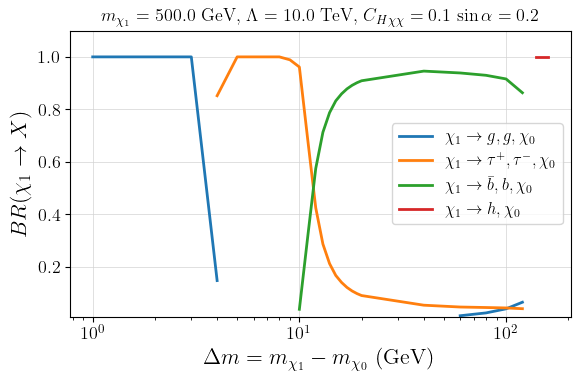

In [7]:
data_red = slhaDF[slhaDF['mass.5000023'] == 500.0]
data_red = data_red.sort_values(by='mass.5000022',ascending=False)

plt.figure(figsize=(6,4))
for col in data_red.columns:
    if 'BRs.5000023.' not in col:
        continue
    if data_red[col].max() < 1e-2:
        continue
    label = col.replace('BRs.','')
    mom,daughters = label.split('.',1)
    daughters = daughters.split(',')
    mom = ptc_labels[int(mom)]
    daughters = [ptc_labels[int(d)] for d in daughters]
    label = r'$%s \to %s$' %(mom,','.join(daughters))
    plt.plot(data_red['mass.5000023']-data_red['mass.5000022'],data_red[col],label=label)
# plt.plot(dataQ['mass55'],dataQ['cross'],label=r'Heavy quark ($M_Q = 2$ TeV, $y_Q = 1$)', color='skyblue')
plt.xscale('log')
# plt.vlines(x=2*172.0,ymin=1e-2,ymax=3,linestyle='dashed',color='gray')
plt.legend(fontsize=12)
plt.ylim(1e-2,1.1)
plt.ylabel(r'$BR(\chi_1 \to X)$')
plt.xlabel(r'$\Delta m = m_{\chi_1}-m_{\chi_0}$ (GeV)')
l0 = data_red.iloc[0]
plt.title(r'$m_{\chi_1} = %1.1f$ GeV, $\Lambda = $ %1.1f TeV, $C_{H\chi\chi} = %1.1f$ $\sin\alpha = %1.1f$ ' %(l0['mass.5000023'],l0['extpar.1']/1e3,l0['extpar.7'],l0['extpar.11']))
plt.tight_layout()
plt.savefig('chi1_BRs_H.png')
plt.show()

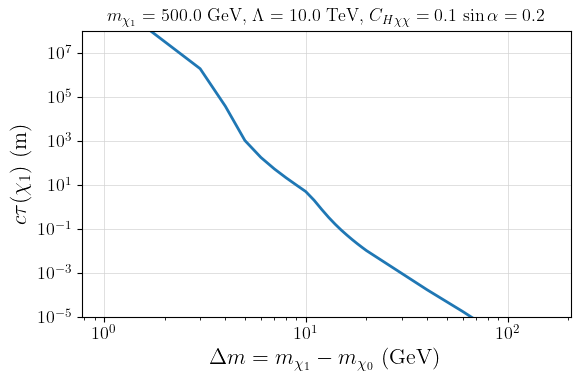

In [8]:
data_red = slhaDF[slhaDF['mass.5000023'] == 500.0]
data_red = data_red.sort_values(by='mass.5000022',ascending=False)

plt.figure(figsize=(6,4))
plt.plot(data_red['mass.5000023']-data_red['mass.5000022'],2e-16/data_red['width.5000023'])
# plt.plot(dataQ['mass55'],dataQ['cross'],label=r'Heavy quark ($M_Q = 2$ TeV, $y_Q = 1$)', color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5,1e8)
plt.ylabel(r'$c \tau(\chi_1)$ (m)')
plt.xlabel(r'$\Delta m = m_{\chi_1}-m_{\chi_0}$ (GeV)')
l0 = data_red.iloc[0]
plt.title(r'$m_{\chi_1} = %1.1f$ GeV, $\Lambda = $ %1.1f TeV, $C_{H\chi\chi} = %1.1f$ $\sin\alpha = %1.1f$ ' %(l0['mass.5000023'],l0['extpar.1']/1e3,l0['extpar.7'],l0['extpar.11']))
plt.tight_layout()
plt.savefig('chi1_lifetime_H.png')
plt.show()